In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [285]:
data = pd.read_csv('obs_movement.csv')

In [286]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [287]:
data.columns

Index(['STATE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'OBSERVER ID',
       'TIME OBSERVATIONS STARTED', 'SAMPLING EVENT IDENTIFIER',
       'PROJECT CODE', 'GROUP IDENTIFIER', 'DATE TIME', 'NUMLIST', 'CLUSTER',
       'LARGEST CLUSTER', 'NAIVE LOCAL', 'NEXT CLUSTER', 'CHECKLIST NUM',
       'LOCAL CLUSTER', 'LOCAL', 'IS URBAN', 'YEAR', 'MONTH'],
      dtype='object')

In [288]:
datalist = []
def createdata(df):
    templist = []
    df = df.sort_values(by=['DATE TIME'])
    # add all clusters to templist inorder
    df.apply(lambda x: templist.append(x['CLUSTER']), axis=1)
    # add templist to datalist
    datalist.append((df.iloc[0]["LOCAL CLUSTER"],templist))

In [289]:
MAXLENGTH = 100

In [290]:
def pad(seq):
    if len(seq) < MAXLENGTH:
        return seq + [0]*(MAXLENGTH-len(seq))
    else:
        return seq[:MAXLENGTH]

In [291]:
data.groupby('OBSERVER ID').apply(createdata)

""


In [292]:
datalist = [(l,x) for l,x in datalist if len(x) > 3]

In [293]:
datalist = [(l, x[:i]) for l, x in datalist for i in range(3, len(x)+1)]

In [294]:
datalist = [(loc,seq[-1],seq[0:-1]) for loc, seq in datalist]

In [295]:
datalist = [(end, [loc]+seq) for loc, end, seq in datalist]

In [296]:
datalist = [(end, pad(seq)) for end, seq in datalist]

In [297]:
encodingdict = {loc: i for i, loc in enumerate(data['CLUSTER'].unique())}
encodingdict[0] = 0

datalist = [(encodingdict[end], [encodingdict[loc] for loc in seq]) for end, seq in datalist]

In [298]:

X = np.array([seq for end, seq in datalist])
y = np.array([end for end, seq in datalist])




In [299]:
y = np.eye(len(encodingdict))[y]

NameError: name 'h' is not defined

In [301]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [302]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((307733, 100), (76934, 100), (307733, 423), (76934, 423))

In [303]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=256, input_shape=(MAXLENGTH, 1), return_sequences=True))
model.add(LSTM(units=256, return_sequences=True))
model.add(LSTM(units=128))
model.add(Dense(units=len(encodingdict), activation='relu'))
model.add(Dense(units=len(encodingdict), activation='relu'))
model.add(Dense(units=len(encodingdict), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [304]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 100, 256)          264192    
                                                                 
 lstm_53 (LSTM)              (None, 100, 256)          525312    
                                                                 
 lstm_54 (LSTM)              (None, 128)               197120    
                                                                 
 dense_55 (Dense)            (None, 423)               54567     
                                                                 
 dense_56 (Dense)            (None, 423)               179352    
                                                                 
 dense_57 (Dense)            (None, 423)               179352    
                                                                 
Total params: 1,399,895
Trainable params: 1,399,895
N

In [305]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=512)

Epoch 1/10
602/602 [==============================] - 124s 200ms/step - loss: 4.6403 - val_loss: 4.2945
Epoch 2/10
602/602 [==============================] - 120s 200ms/step - loss: 3.9988 - val_loss: 3.8801
Epoch 3/10
602/602 [==============================] - 121s 201ms/step - loss: 3.7166 - val_loss: 3.6574
Epoch 4/10
602/602 [==============================] - 121s 201ms/step - loss: 3.5470 - val_loss: 3.5153
Epoch 5/10
602/602 [==============================] - 122s 203ms/step - loss: 3.4206 - val_loss: 3.4273
Epoch 6/10
602/602 [==============================] - 121s 201ms/step - loss: 3.3211 - val_loss: 3.3397
Epoch 7/10
602/602 [==============================] - 121s 201ms/step - loss: 3.2457 - val_loss: 3.2822
Epoch 8/10
602/602 [==============================] - 121s 201ms/step - loss: 3.1849 - val_loss: 3.2361
Epoch 9/10
602/602 [==============================] - 121s 201ms/step - loss: 3.1305 - val_loss: 3.1963
Epoch 10/10
602/602 [==============================] - 121s 201m

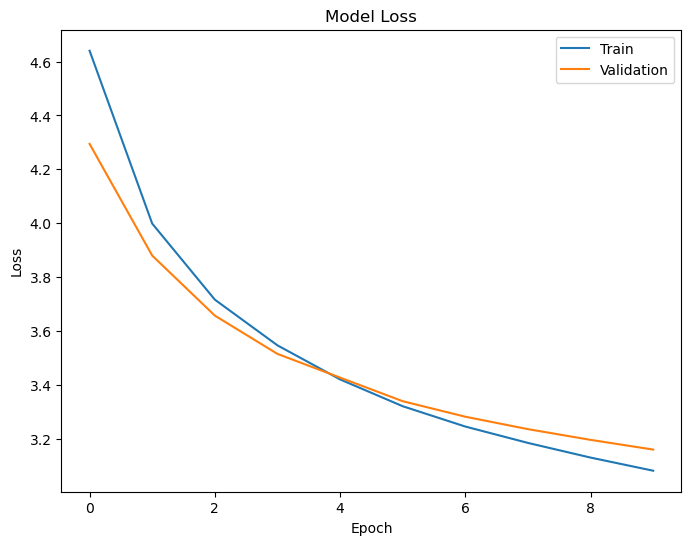

In [330]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [311]:
model.save('movementmodel.keras')

In [307]:
import random as rand

In [328]:
def inference(local_cluster, starting_location):
    starting_location = encodingdict[starting_location]
    local_cluster = encodingdict[local_cluster]
    generated_sequence = [local_cluster]+[starting_location]
    print("GENERATED SEQUENCE: ", generated_sequence)
    generated_sequence = pad(generated_sequence)
    for i in range(100 - 2):
        next_location_probs = model.predict(np.array([generated_sequence]), verbose=0)[0]

        # next_location = rand.choices(range(len(next_location_probs)), next_location_probs)[0]
        # while next_location == generated_sequence[i+1]:
        #     next_location = rand.choices(range(len(next_location_probs)), next_location_probs)[0]
        # generated_sequence[i+2] = next_location

        candidates = np.argsort(next_location_probs)[-5:]
        next_location = rand.choice(candidates)
        while next_location == generated_sequence[i+1]:
            next_location = rand.choice(candidates)
        generated_sequence[i+2] = next_location




        # next_location = np.argmax(next_location_probs)
        # if next_location != generated_sequence[i+1]:
        #     generated_sequence[i+2] = next_location
        # else:
        #     generated_sequence[i+2] = np.argsort(next_location_probs)[-2]
    return generated_sequence


In [329]:
seq = inference(1000, 1011)
seq = [list(encodingdict.keys())[list(encodingdict.values()).index(i)] for i in seq]
print(seq)

GENERATED SEQUENCE:  [42, 76]
[1000, 1011, 1060, 1000, 1060, 1000, 1008, 1031, 1000, 1016, 1056, 1008, 1016, 1013, 1031, 1013, 1000, 1016, 1056, 1016, 1013, 1031, 1008, 1013, 1008, 1013, 1000, 1016, 1008, 1056, 1016, 1008, 1056, 1016, 1000, 1016, 1056, 1031, 1008, 1056, 1008, 1056, 1016, 1008, 1031, 1008, 1016, 1000, 1056, 1000, 1031, 1016, 1031, 1016, 1008, 1031, 1056, 1000, 1008, 1031, 1008, 1016, 1000, 1016, 1031, 1016, 1056, 1000, 1008, 1000, 1016, 1000, 1031, 1016, 1031, 1008, 1000, 1031, 1056, 1031, 1056, 1000, 1016, 1031, 1016, 1008, 1056, 1008, 1031, 1056, 1031, 1056, 1008, 1056, 1011, 1000, 1031, 1056, 1016, 1031]
